In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
sns.set()

# Case 1 - Predicting airplane load factors
**The case is given by Copenhagen Optimisation which works for airport to predict passenger flows to optimise boarding, security etc. in airports. They believe that employing maching learning models to predict the load factor on the scheduled planes will help improve their models.**


## Presenting the data

The data consists of 8 independent variables:
- `ScheduleTime` (TimeStamp): Is the time of departure scheduled for the aircraft. $36770$ Scheduled flights. Timestamp: (YYYY-MM-DD HH:mm:ss)
- `Airline` (*Categorical*): The Airline managing the aircraft.  $96$ different Airlines.
- `FlightNumber` (*Categorical*): The flight number. $809$ different flightnumbers.
- `Destination` (*Categorical*): The destination airport. $231$ different destination airports.
- `AircraftType` (*Categorical*): The type of aircraft. $57$ different Aircraft types
- `FlightType` (*Categorical*): The type of flight. $3$ different flight types: Charter, Scheduled, Other.
- `Sector` (*Categorical*): The destination country. $13$ different sectors. 
- `SeatCapacity`(*Integer*): The number of seats in the aircraft.

And 1 response variable:
- `LoadFactor` (*float / fraction*): The fraction of passengers on board compared to the total SeatCapacity.


Below is the data loaded and presented as a DataFrame.

In [18]:
# Load data
df = pd.read_excel("data/realised_schedule.xlsx")


0       2021-01-01 06:35:00
1       2021-01-01 10:35:00
2       2021-01-01 12:05:00
3       2021-01-01 13:20:00
4       2021-01-01 14:20:00
                ...        
36765   2022-02-08 18:30:00
36766   2022-02-08 19:30:00
36767   2022-02-08 19:40:00
36768   2022-02-08 19:05:00
36769   2022-02-08 20:35:00
Name: ScheduleTime, Length: 36770, dtype: datetime64[ns]

**We belive that both the FlightNumber and the SeatCapacity is irrelevant for making predictions** <br>
We have $809$ different flight numbers which would code to $809$ parameters as each has to be considered independently. The FlightNumber is given independent of the destination, flight type etc ...

The SeatCapacity depens on the AircraftType and we believe this might explain more about the loadfactor, as some flight type might be special and usually more or lessed loaded.

**Sectors vs. Destinations**<br>
As the below table demonstrates most sectors only have one destination airport, which means that many Destination is equivalent to the sector. This will create a strong collinearity in the observations and including both will not improve the model. The question is which to keep.
CA and US have $65$ and $154$ destinations respectively and they might differ alot in loadfactors as some are more visited than others.

The same holds for Airlines. Some Airlines ony go to one sector / destination maybe and observations are therefore also highly correlated.

In [15]:
df.groupby("Sector").agg({'ScheduleTime': lambda x: len(x.unique()), 'Airline': lambda x: len(x.unique())})

,ScheduleTime,Airline
Sector,,
AE,165,1
CA,15454,54
CN,44,2
DK,95,1
EG,88,2
IQ,3,2
IS,449,4
MX,1,1
NL,1,1


**Domain Specific Feature selection**<br>
Based on the above findings (*And maybe some correlation and stuff ??*) a simple preprocess domain specific feature selection would be to exclude `FlightNumber`, `SeatCapacity` and `Sector`.

This might also depend on the test data... If, say, a flight in march is traveling to a different destination in a sector. Or the number of flights to destinations might depend heavily on the sector, due to, say, covid restrictions.

One could also simply exclude the Destinations which are alone in a Sector and keep the rest.


- Look at which Sectors and Destinations: Some are the same.
- Look at Airline and Sectors: Some Airlines are very limited to one sector. Or at least the sector is only visited by this airline.
- Consider the importance of FlightNumber and SeatCapacity.
- We need to include the same features which are in the test data ... 


In [20]:
pd.df.ScheduleTime - df.ScheduleTime[0]


0         0 days 00:00:00
1         0 days 04:00:00
2         0 days 05:30:00
3         0 days 06:45:00
4         0 days 07:45:00
               ...       
36765   403 days 11:55:00
36766   403 days 12:55:00
36767   403 days 13:05:00
36768   403 days 12:30:00
36769   403 days 14:00:00
Name: ScheduleTime, Length: 36770, dtype: timedelta64[ns]

**Time-Series data**

To get a better understanding of the loadfactor during the time period provided, the daily average load factor is visualised as a funciton of time below.

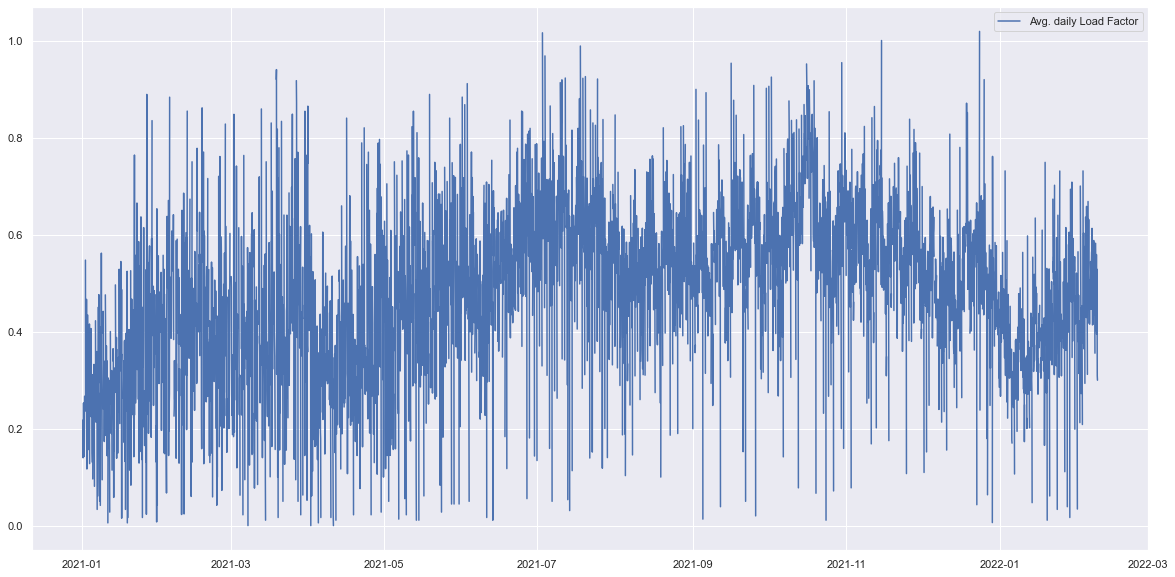

In [19]:
fig,ax = plt.subplots(figsize = (20,10))

df2 = df.set_index("ScheduleTime")

mean = df2.LoadFactor.resample('2h').mean()
ax.plot(mean, label = 'Avg. daily Load Factor')
ax.legend();

**Quick observations** <br>
On the above figure a high frequency periodic pattern is recognized, perhaps a change in weekdays and weekends? <br>
There also seems to be a peak in the summertime and a drop around new years. 

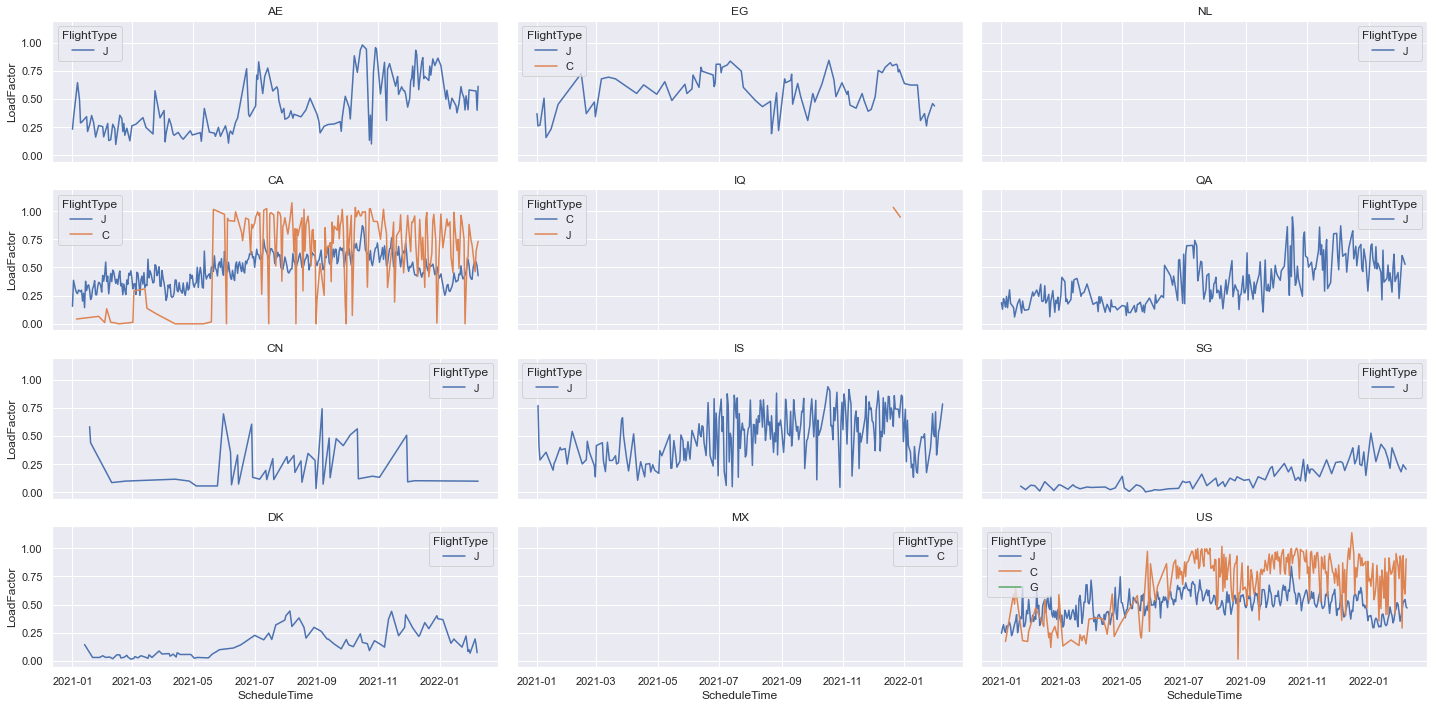

In [68]:
df2 = df.copy()
df2.ScheduleTime = pd.to_datetime(df.ScheduleTime).dt.date
df2
means = df2.groupby(["Sector", "ScheduleTime", 'FlightType']).aggregate({'LoadFactor':'mean'}).reset_index()

dests = means.Sector.unique()

fig, ax = plt.subplots(4,3, figsize = (20,10), sharey = True, sharex=True)

for i in range(len(dests)):
    
    a = ax[i % 4, i // 4]
    sns.lineplot(data = means[means.Sector == dests[i]], x = 'ScheduleTime', y = 'LoadFactor', hue = 'FlightType', legend = True, ax = a, ls = '-')
    a.set_title(dests[i])

fig.tight_layout()


ValueError: Could not interpret value `Destination` for parameter `hue`

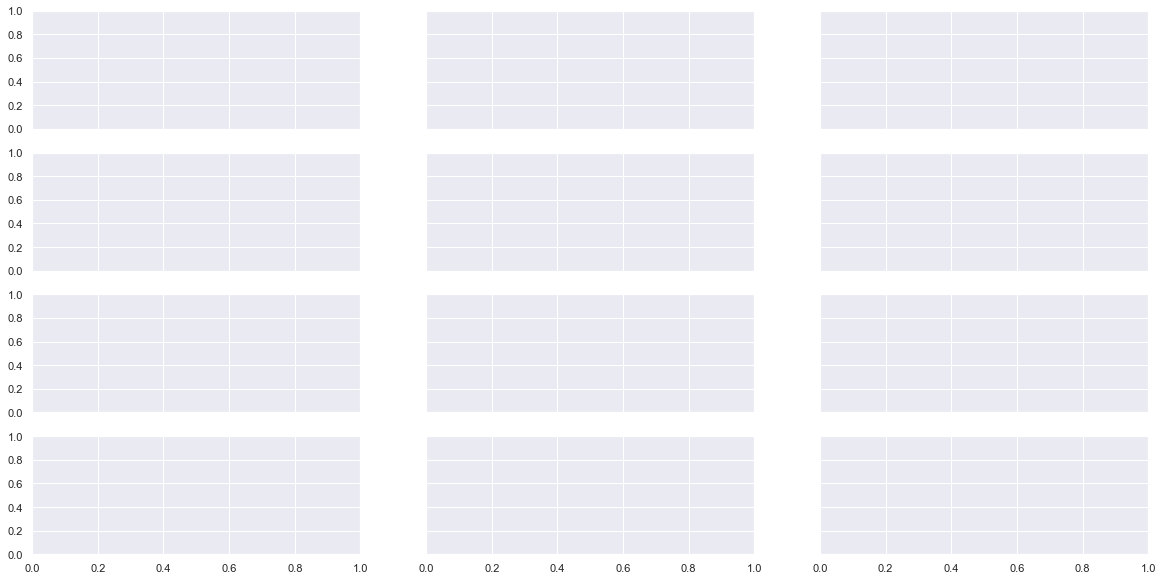

In [70]:
fig, ax = plt.subplots(4,3, figsize = (20,10), sharey = True, sharex=True)

for i in range(len(dests)):
    
    a = ax[i % 4, i // 4]
    sns.lineplot(data = means[means.Sector == dests[i]], x = 'ScheduleTime', y = 'LoadFactor', hue = 'Destination', legend = False, ax = a, ls = '-.')
    a.set_title(dests[i])

fig.tight_layout()

In [32]:
data = pd.get_dummies(df).drop(["FlightNumber", "SeatCapacity", "ScheduleTime"], axis = 1)
y = data.LoadFactor.values
X = data.drop("LoadFactor", axis = 1).values

data

,LoadFactor,Airline_AY,Airline_BJ,Airline_BT,Airline_BZ,Airline_CL,Airline_CN,Airline_DO,Airline_DT,Airline_DU,...,Sector_CN,Sector_DK,Sector_EG,Sector_IQ,Sector_IS,Sector_MX,Sector_NL,Sector_QA,Sector_SG,Sector_US
0,0.408451,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0.189189,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.570423,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0.333333,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0.204301,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36765,0.522222,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
36766,0.532051,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
36767,0.602564,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
36768,0.417989,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


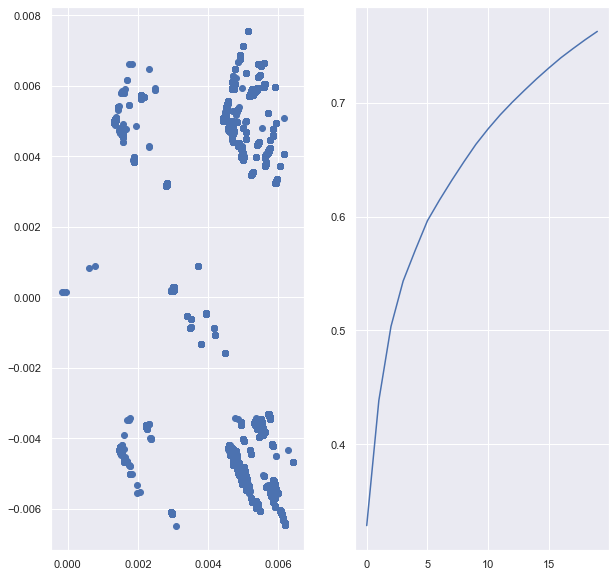

In [37]:
from sklearn.decomposition import PCA

pca = PCA(n_components=20)


pca.fit(X.T)

fig, ax = plt.subplots(ncols = 2, figsize = (10,10))


x, y = pca.components_[:2]
ax[0].scatter(x,y)
ax[1].plot(pca.explained_variance_ratio_.cumsum())

In [115]:
from sklearn.model_selection import KFold
from sklearn import linear_model
from sklearn import preprocessing as preproc # load preprocessing function

def centerData(data):
    
    mu = np.mean(data,axis=0)
    data = data - mu
    
    return data, mu


K = 10
M = 20
lambdas = np.logspace(-4, 1, M)
MSE = np.zeros((K, M))

kf = KFold(n_splits=K, shuffle = True)


mse_train = np.zeros((K, M))
mse_test  = np.zeros((K,M))
betas     = np.zeros((K,M,X.shape[-1]))
for i, (train_index, test_index) in enumerate(kf.split(X)):
    print(f"{i} out of {K} folds")
    X_train, X_test = X[train_index, :], X[test_index, :],
    y_train, y_test = y[train_index], y[test_index]
    

    for j, lambda_ in enumerate(lambdas):
        model = linear_model.Ridge(alpha = lambda_)
        model.fit(X_train, y_train)
        y_hat_train = model.predict(X_train)
        y_hat_test  = model.predict(X_test)

        err_train = pow(y_train - y_hat_train, 2).mean()
        err_test = pow(y_test - y_hat_test, 2).mean()

        mse_train[i,j] = err_train
        mse_test[i,j] = err_test

        beta = model.coef_.ravel()

        betas[i,j,:] = beta

    

0 out of 10 folds
1 out of 10 folds
2 out of 10 folds
3 out of 10 folds
4 out of 10 folds
5 out of 10 folds
6 out of 10 folds
7 out of 10 folds
8 out of 10 folds
9 out of 10 folds


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


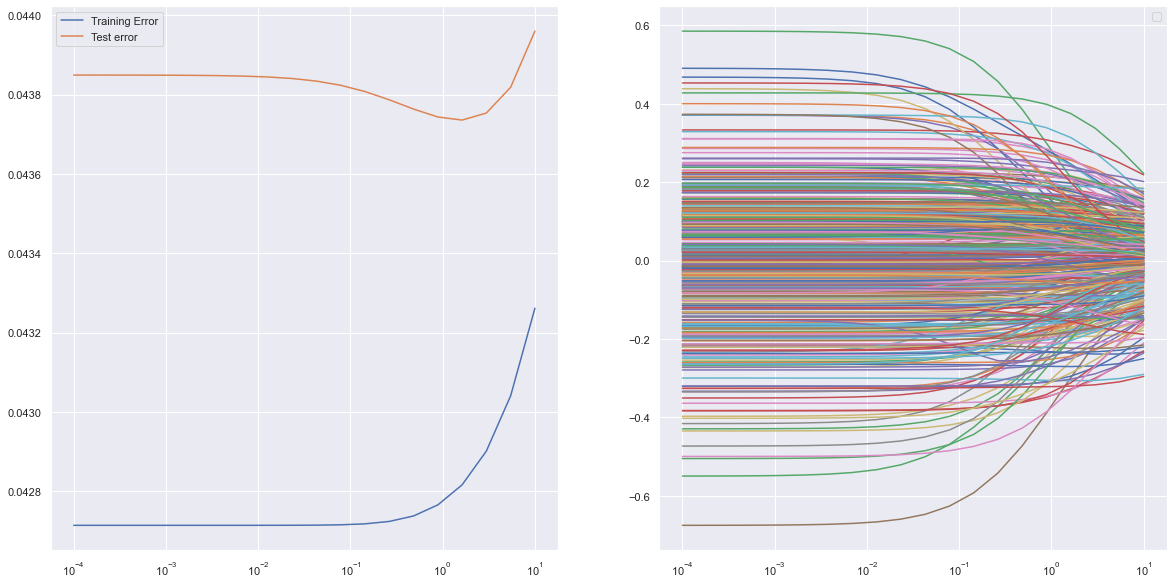

In [120]:
fig, ax = plt.subplots(ncols = 2, figsize = (20,10))

ax[0].plot(lambdas, mse_train.mean(0), label = 'Training Error')
ax[0].plot(lambdas, mse_test.mean(0),  label = 'Test error')
ax[0].legend()
ax[0].set_xscale('log')

ax[1].plot(lambdas, betas.mean(0))
ax[1].legend()
ax[1].set_xscale('log')

In [123]:
from sklearn.model_selection import KFold
from sklearn import linear_model
from sklearn import preprocessing as preproc # load preprocessing function

def centerData(data):
    
    mu = np.mean(data,axis=0)
    data = data - mu
    
    return data, mu


K = 5
M = 10
lambdas = np.logspace(-10, 1, M)
MSE = np.zeros((K, M))

kf = KFold(n_splits=K, shuffle = True)


mse_train = np.zeros((K, M))
mse_test  = np.zeros((K,M))
betas     = np.zeros((K,M,X.shape[-1]))
for i, (train_index, test_index) in enumerate(kf.split(X)):
    print(f"{i} out of {K} folds")
    X_train, X_test = X[train_index, :], X[test_index, :],
    y_train, y_test = y[train_index], y[test_index]
    

    for j, lambda_ in enumerate(lambdas):
        model = linear_model.Lasso(alpha = lambda_)
        model.fit(X_train, y_train)
        y_hat_train = model.predict(X_train)
        y_hat_test  = model.predict(X_test)

        err_train = pow(y_train - y_hat_train, 2).mean()
        err_test = pow(y_test - y_hat_test, 2).mean()

        mse_train[i,j] = err_train
        mse_test[i,j] = err_test

        beta = model.coef_.ravel()

        betas[i,j,:] = beta

    

0 out of 5 folds


c:\Users\peter\OneDrive - Danmarks Tekniske Universitet\DTU\8. Semester\02582-Computational_Data_Analysis\env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.292e+02, tolerance: 2.187e-01
  model = cd_fast.enet_coordinate_descent(


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


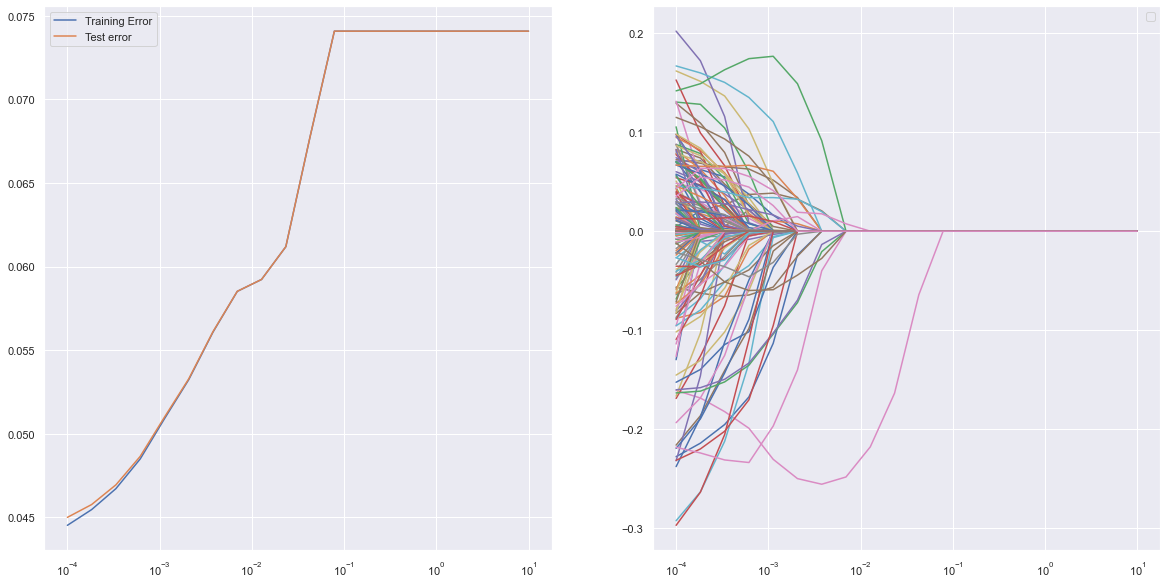

In [122]:
fig, ax = plt.subplots(ncols = 2, figsize = (20,10))

ax[0].plot(lambdas, mse_train.mean(0), label = 'Training Error')
ax[0].plot(lambdas, mse_test.mean(0),  label = 'Test error')
ax[0].legend()
ax[0].set_xscale('log')

ax[1].plot(lambdas, betas.mean(0))
ax[1].legend()
ax[1].set_xscale('log')